# Task 1 - State‑Vector Quantum Computer Simulator

## Task 1.1 - State‑vector representation

In [ ]:
# @title
import numpy as np
DTYPE = np.complex128

def ket00():
    """Return |00> as a length‑4 complex column vector."""
    v = np.zeros(4, dtype=DTYPE)
    v[0] = 1.0
    return v

def normalize(v: np.ndarray) -> np.ndarray:
    n = np.linalg.norm(v)
    if n == 0:
        raise ValueError("Zero vector cannot be normalized.")
    return v / n


# Example
psi = ket00()
assert np.isclose(np.linalg.norm(psi), 1.0)

We use the computational basis ordered as ∣00⟩,∣01⟩,∣10⟩,∣11⟩
mapping a bitstring 𝑏1, 𝑏2 to the integer index (2x𝑏1+𝑏2)), such that integer index of ∣00⟩ = 0, ∣01⟩ = 1, ∣10⟩ = 2, ∣11⟩ = 3.

## Task 1.2 - Quantum gate implementation

In [ ]:
# @title
# 1‑qubit and 2‑qubit gate definitions (matrix form)
I2 = np.array([[1, 0], [0, 1]], dtype=DTYPE)
H  = (1/np.sqrt(2)) * np.array([[1, 1], [1, -1]], dtype=DTYPE)

# CNOT with control = q0 (MSB), target = q1 (LSB) in basis |q0 q1>
CNOT_01 = np.array([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,0,1],
    [0,0,1,0]
], dtype=DTYPE)

# Expand a 1‑qubit unitary U to a 2‑qubit operator acting on target qubit t in |q0 q1> order
# t = 0 applies to q0 (MSB); t = 1 applies to q1 (LSB)

def expand_1q(U: np.ndarray, t: int) -> np.ndarray:
    if t == 0:   # act on q0 (MSB)
        return np.kron(U, I2)
    elif t == 1: # act on q1 (LSB)
        return np.kron(I2, U)
    else:
        raise ValueError("target index must be 0 or 1")

# Apply a gate matrix to a state vector

def apply(U: np.ndarray, psi: np.ndarray) -> np.ndarray:
    return U @ psi

# Quick unit tests
assert np.allclose(H.conj().T @ H, I2)
assert np.allclose(CNOT_01.conj().T @ CNOT_01, np.eye(4))

The control and target convention for CNOT above is control = q0 (MSB), target = q1 (LSB), respectively. The basis is ordered as {∣00⟩,∣01⟩,∣10⟩,∣11⟩} with q0 as the MSB and q1 as the LSB. CNOT leaves the first two states (𝑞0=0) unchanged and swaps the last two (𝑞0=1), which exactly means “control on 𝑞0, flip target 𝑞1.

## Task 1.3 - Circuit simulation: Bell state

In [ ]:
# @title
def bell_state() -> np.ndarray:
    psi = ket00()
    # H on q0 (MSB), then CNOT(control=q0, target=q1)
    psi = apply(expand_1q(H, t=0), psi)
    psi = apply(CNOT_01, psi)
    return normalize(psi)

psi_bell = bell_state()
print("Bell state vector:", np.round(psi_bell, 6))
# Expected amplitudes (up to a global phase): [1/√2, 0, 0, 1/√2]

Bell state vector: [0.707107+0.j 0.      +0.j 0.      +0.j 0.707107+0.j]


The output shows amplitudes of 0.707107 (5 s.f.)=~1/√2 for ∣00⟩ and ∣11⟩, with zero amplitude for ∣01⟩ and ∣10⟩. In words, this means the final state is an equal superposition of ∣00⟩ and ∣11⟩, which is exactly the expected result of the Bell state vector.

## Task 1.4 - Output, verification, and circle‑plot comparison

{'00': 4983, '01': 0, '10': 0, '11': 5017}


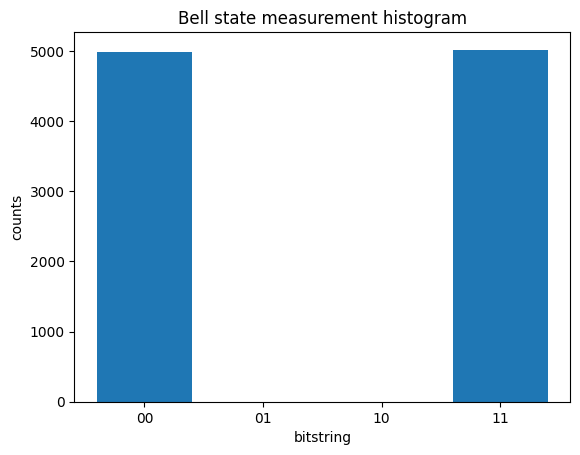

In [ ]:
# @title
import matplotlib.pyplot as plt

BITSTR = ["00","01","10","11"]

def sample_bitstrings(psi: np.ndarray, shots: int = 10_000, seed: int = 7):
    rng = np.random.default_rng(seed)
    probs = np.abs(psi)**2
    idx = rng.choice(4, size=shots, p=probs)
    return idx

# Sample from Bell state
shots = 10_000
idx = sample_bitstrings(psi_bell, shots=shots)

# Make histogram
counts = {b: int(np.sum(idx == i)) for i, b in enumerate(BITSTR)}
print(counts)
plt.bar(counts.keys(), counts.values())
plt.xlabel("bitstring"); plt.ylabel("counts"); plt.title("Bell state measurement histogram")
plt.show()

The Bell state has equal probability amplitudes for ∣00⟩ and ∣11⟩, ∣0.707∣^2=0.5. Considering the sampling probability, the results correspond to this probability, where the number of ∣00⟩ = 4983, similar to the number of ∣11⟩ = 5017, represened by almost equal bars in the histogram.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 73.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 71.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.2 MB/s eta 0:00:00


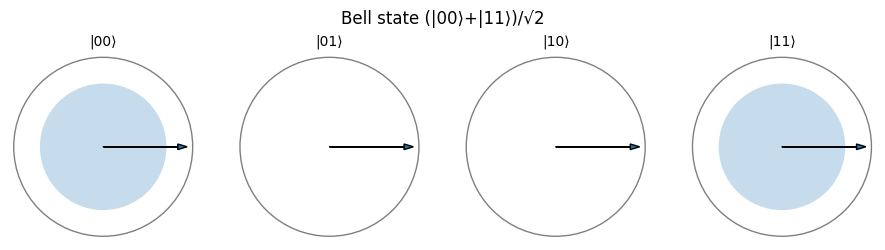

In [ ]:
!pip install -q "qiskit>=2.1" qiskit-aer

import math
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer

def statevector_from_aer(circ: QuantumCircuit) -> np.ndarray:
    backend = Aer.get_backend("aer_simulator_statevector")
    tqc = transpile(circ, backend)
    result = backend.run(tqc).result()
    return np.asarray(result.get_statevector(tqc), dtype=np.complex128)

class QubitSystem:
    def __init__(self, statevector: np.ndarray, label: str = "Qubit System"):
        self.label = label
        self.set_statevector(statevector)

    def set_statevector(self, statevector: np.ndarray):
        sv = np.asarray(statevector, dtype=np.complex128).flatten()
        if sv.ndim != 1:
            raise ValueError("Statevector must be 1D.")
        n_states = sv.size
        n_qubits = int(round(math.log2(n_states)))
        if 2**n_qubits != n_states:
            raise ValueError("Length must be a power of 2.")
        # Defensive normalization (harmless if already normalized)
        norm = np.linalg.norm(sv)
        if norm != 0 and not np.isclose(norm, 1.0):
            sv = sv / norm

        self.n_qubits = n_qubits
        self.n_states = n_states
        self.amps  = sv
        self.prob  = np.abs(sv)**2
        self.phase = np.angle(sv)

    def viz_circle(self, max_cols: int = 8, figsize_scale: float = 2.3):
        cols = max(1, min(max_cols, self.n_states))
        rows = int(math.ceil(self.n_states / cols))

        fig, axes = plt.subplots(
            rows, cols,
            figsize=(cols*figsize_scale, rows*(figsize_scale+0.2))
        )
        axes = np.atleast_2d(axes)

        def bitstr(i: int, n: int) -> str:
            return format(i, f"0{n}b")

        for idx in range(rows * cols):
            r, c = divmod(idx, cols)
            ax = axes[r, c]
            ax.set_aspect("equal")
            ax.set_xlim(0, 1); ax.set_ylim(0, 1)
            ax.axis("off")

            if idx >= self.n_states:
                ax.set_visible(False)
                continue

            # Outer reference circle
            ax.add_patch(plt.Circle((0.5, 0.5), 0.48, fill=False, lw=1.0, alpha=0.5))

            # Filled disk: radius ∝ sqrt(probability) so area ∝ probability
            radius = 0.48 * np.sqrt(self.prob[idx])
            ax.add_patch(plt.Circle((0.5, 0.5), radius, alpha=0.25))

            # Phase arrow
            angle = self.phase[idx]
            L = 0.45
            x2 = 0.5 + L * np.cos(angle)
            y2 = 0.5 + L * np.sin(angle)
            ax.arrow(0.5, 0.5, x2 - 0.5, y2 - 0.5,
                     head_width=0.03, head_length=0.05, length_includes_head=True)

            ax.set_title(f"|{bitstr(idx, self.n_qubits)}⟩", fontsize=10)

        fig.suptitle(self.label, fontsize=12)
        plt.tight_layout()
        plt.show()

qc = QuantumCircuit(2, name="Bell")
qc.h(0)
qc.cx(0, 1)
qc.save_statevector()     # Save state vector after all gates have been applied

sv = statevector_from_aer(qc)
QubitSystem(sv, label="Bell state (|00⟩+|11⟩)/√2").viz_circle()

The circle plot shows two dominant components ∣00⟩ and ∣11⟩ via the shaded regions (nonzero probability), while ∣01⟩ and ∣10⟩ have zero probability. Their relative phase is indicated by the arrows (here both pointing right, so same phase).

# Task 2 - State‑Vector SWAP Test

In [ ]:
import numpy as np

# numeric dtype
DTYPE = np.complex128

# Hadamard gate
H = (1/np.sqrt(2)) * np.array([[1, 1],
                               [1, -1]], dtype=DTYPE)

# helper: Kronecker product of a list of matrices
def kron_all(mats):
    out = mats[0]
    for m in mats[1:]:
        out = np.kron(out, m)
    return out

def expand_1q_n(U, t, n):
    """
    Expand a 1-qubit unitary U to act on target qubit t in an n-qubit system.
    Qubit ordering: [0,...,n-1] with 0 = leftmost (most significant).
    """
    ops = []
    for i in range(n):
        if i == t:
            ops.append(U)
        else:
            ops.append(np.eye(2, dtype=DTYPE))
    return kron_all(ops)

# Build CSWAP (8x8)
# CSWAP = |0><0| ⊗ I_4 + |1><1| ⊗ SWAP_2
P0 = np.array([[1,0],[0,0]], dtype=DTYPE)
P1 = np.array([[0,0],[0,1]], dtype=DTYPE)

SWAP_2 = np.array([
    [1,0,0,0],
    [0,0,1,0],
    [0,1,0,0],
    [0,0,0,1]
], dtype=DTYPE)

CSWAP = np.kron(P0, np.eye(4, dtype=DTYPE)) + np.kron(P1, SWAP_2)

def swap_test(psi: np.ndarray, phi: np.ndarray):
    psi = psi / np.linalg.norm(psi)
    phi = phi / np.linalg.norm(phi)

    # initial state |0>⊗|ψ>⊗|φ>
    init = np.kron(np.array([1,0], dtype=DTYPE), np.kron(psi, phi))

    # H on ancilla
    U_Ho = expand_1q_n(H, t=0, n=3)
    state = U_Ho @ init
    # CSWAP
    state = CSWAP @ state
    # final H on ancilla
    state = U_Ho @ state

    probs = np.abs(state)**2
    prob_1 = probs[4:].sum()   # ancilla=1 indices (MSB-first ordering)

    F_hat = 1 - 2*prob_1
    F_exact = float(np.abs(np.vdot(psi, phi))**2)

    return prob_1, F_hat, F_exact

# Define common states
zero = np.array([1,0], dtype=DTYPE)
one  = np.array([0,1], dtype=DTYPE)
plus = (1/np.sqrt(2)) * np.array([1,1], dtype=DTYPE)

# Run tests
tests = [
    ("|ψ⟩=|φ⟩=|0⟩", zero, zero),
    ("|ψ⟩=|0⟩, |φ⟩=|1⟩", zero, one),
    ("|ψ⟩=|+⟩, |φ⟩=|0⟩", plus, zero),
]

for label, psi, phi in tests:
    prob_1, F_hat, F_exact = swap_test(psi, phi)
    print(f"{label} ⇒ F_exact={F_exact:.3f}, F_hat={F_hat:.3f}, P(output=1)={prob_1:.3f}")

|ψ⟩=|φ⟩=|0⟩ ⇒ F_exact=1.000, F_hat=1.000, P(output=1)=0.000
|ψ⟩=|0⟩, |φ⟩=|1⟩ ⇒ F_exact=0.000, F_hat=0.000, P(output=1)=0.500
|ψ⟩=|+⟩, |φ⟩=|0⟩ ⇒ F_exact=0.500, F_hat=0.500, P(output=1)=0.250


The exact fidelity is computed directly from the inner product of the two states, while the swap test estimate is inferred from measurement outcomes on the ancilla qubit.

Since
|0> vs |0> → 𝐹hat≈1.000, 𝐹exact=1.000, (perfect overlap) </br>
|0> vs |1> → 𝐹hat≈0.000, 𝐹exact=0.000, (orthogonal, no overlap) </br>
|0> vs |+> → 𝐹hat≈0.500, 𝐹exact=0.500, (half overlap)

the ancilla’s output distribution provides an operational way to estimate fidelity without having to compute the inner product directly.

Furthermore, the smaller the probability of measuring 1 on the ancilla (output bit), the larger the fidelity between the two states.

# Bonus Exercise - Quantum State Comparison with the Multiqubit SWAP Test

## Task B.1 - Basis vs |5>: design, simulate, evaluate

In [ ]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator

# State preparation helpers
def prepare_basis(qc, qreg, k):
    """Prepare 3-qubit basis state |k> on register qreg (MSB-first)."""
    bits = [(k >> i) & 1 for i in reversed(range(3))]
    for i, b in enumerate(bits):
        if b == 1:
            qc.x(qreg[i])


# Controlled swap (manual decomposition)
def cswap_decomp(qc, ctrl, a, b):
    qc.cx(b, a)
    qc.ccx(ctrl, a, b)
    qc.cx(b, a)


# Build SWAP test circuit
def build_swap3(ref_k, test_k):
    q_out = QuantumRegister(1, "out")
    q_ref = QuantumRegister(3, "ref")
    q_test = QuantumRegister(3, "test")
    c_out = ClassicalRegister(1, "c_out")

    qc = QuantumCircuit(q_out, q_ref, q_test, c_out)
    prepare_basis(qc, q_ref, ref_k)
    prepare_basis(qc, q_test, test_k)


    qc.h(q_out[0])
    for i in range(3):
        cswap_decomp(qc, q_out[0], q_ref[i], q_test[i])
    qc.h(q_out[0])
    qc.measure(q_out[0], c_out[0])
    return qc

# Run experiment
def run_swap3(ref_k, test_k, shots=2000, repeats=20):
    sim = AerSimulator()
    Fhats, P1s = [], []
    for _ in range(repeats):
        qc = build_swap3(ref_k, test_k)
        job = sim.run(transpile(qc, sim), shots=shots)
        counts = job.result().get_counts()
        p1 = counts.get('1', 0) / shots
        Fhat = 1 - 2*p1
        P1s.append(p1); Fhats.append(Fhat)
    return np.mean(Fhats), np.std(Fhats, ddof=1)/np.sqrt(repeats), np.mean(P1s), np.std(P1s, ddof=1)/np.sqrt(repeats)


run_swap3


NameError: name 'run_swap' is not defined

How we distributed control:

How many two‑qubit/three‑qubit gates we used:

In [ ]:
from qiskit import QuantumCircuit, Aer, transpile
from qiskit.visualization import plot_histogram
from numpy.random import default_rng
import numpy as np

# Create the 3-qubit SWAP test circuit
def swap_test_3qubit(reference_state, test_state):
    # reference_state and test_state are binary strings like '101'
    qc = QuantumCircuit(7, 1)  # 1 control + 3 ref + 3 test

    # Prepare reference state
    for i, bit in enumerate(reference_state):
        if bit == '1':
            qc.x(i+1)

    # Prepare test state
    for i, bit in enumerate(test_state):
        if bit == '1':
            qc.x(i+4)

    # Apply H gate to control
    qc.h(0)

    # Controlled SWAP across pairs
    for i in range(3):
        qc.cswap(0, i+1, i+4)

    # Apply final H to control
    qc.h(0)

    # Measure control qubit
    qc.measure(0, 0)

    return qc

# Simulation helper
def run_swap_test(reference_state='000', test_state='000', shots=1024):
    qc = swap_test_3qubit(reference_state, test_state)
    simulator = Aer.get_backend('aer_simulator')
    tqc = transpile(qc, simulator)
    result = simulator.run(tqc, shots=shots).result()
    counts = result.get_counts()

    # Estimate fidelity from P(0)
    p0 = counts.get('0', 0) / shots
    fidelity_est = 2 * p0 - 1
    return fidelity_est, counts, qc

# Run tests
if __name__ == '__main__':
    rng = default_rng()

    ref_state = '101'
    test_state_same = '101'
    test_state_diff = format(rng.integers(0, 8), '03b')

    fid_same, counts_same, qc_same = run_swap_test(ref_state, test_state_same)
    fid_diff, counts_diff, qc_diff = run_swap_test(ref_state, test_state_diff)

    print(f"Reference: {ref_state}\n")
    print(f"Test (same): {test_state_same}, Fidelity ≈ {fid_same:.3f}, Counts: {counts_same}")
    print(f"Test (diff): {test_state_diff}, Fidelity ≈ {fid_diff:.3f}, Counts: {counts_diff}")


ImportError: cannot import name 'Aer' from 'qiskit' (/usr/local/lib/python3.12/dist-packages/qiskit/__init__.py)

## Task B.2 - Introducing superposition

# AI Assistance Disclosure

Generally, ChatGPT was used to guide us in the debugging of code.

**Per-Task Usage:**  
- **Task 1:** ChatGPT helped with the interpretation of the printed output.

Query: "this is what is printed: Bell state vector: [0.707107+0.j 0. +0.j 0. +0.j 0.707107+0.j]"

Answer: "Perfect ✅

Your printed result

[0.707107+0.j  0.      +0.j  0.      +0.j  0.707107+0.j]

is exactly the state vector... since the first entry corresponds to
∣00⟩, the last entry corresponds to ∣11⟩, and both have equal amplitude
1/√2.

So your implementation correctly produces the Bell state."

- **Task 2:**

Query: "what is the output bit"

Answer: "Good question — in the SWAP test, the output bit refers to the ancilla qubit (the extra qubit you add at the start of the circuit).

How it works:..."

- **Bonus:**

**Validation:** AI outputs were tested in the notebook, adapted to match variable names and environment, and checked with documentation and sample data to ensure correctness.

